In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import norm
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test

Read the data

In [2]:
DatOriginal = pd.read_csv("DatasetsMedicalResearch/Prognosis for women with breast cancer.dat", sep="\s+")

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_3936/804963022.py:1: SyntaxWarning: invalid escape sequence '\s'
  DatOriginal = pd.read_csv("DatasetsMedicalResearch/Prognosis for women with breast cancer.dat", sep="\s+")


In [3]:
DatOriginal.head()

,stain,time,status
0,1,23,1
1,1,47,1
2,1,69,1
3,1,70,0
4,1,71,0


In [4]:
DatOriginalNegative = DatOriginal[DatOriginal['stain']==1]
DatOriginalPositive = DatOriginal[DatOriginal['stain']==2]

Plot survivor function for each group

<Axes: xlabel='timeline'>

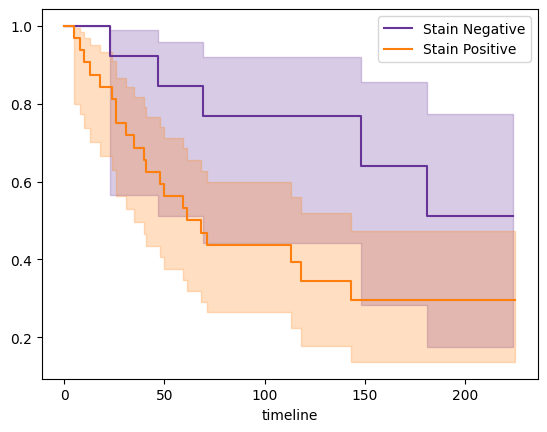

In [5]:
kmf = KaplanMeierFitter()

ax = plt.subplot(111)
kmf.fit(DatOriginalNegative['time'], event_observed=DatOriginalNegative['status'], label="Stain Negative")
kmf.plot_survival_function(ax=ax, color='rebeccapurple')

kmf.fit(DatOriginalPositive['time'], event_observed=DatOriginalPositive['status'], label="Stain Positive")
kmf.plot_survival_function(ax=ax)

Hypothesis test of equal survivor function

In [6]:
logrank_test(
    DatOriginalNegative['time'],
    DatOriginalPositive['time'],
    DatOriginalNegative['status'],
    DatOriginalPositive['status']
)

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           3.51 0.06      4.04

In [7]:
logrank_test(
    DatOriginalNegative['time'],
    DatOriginalPositive['time'],
    DatOriginalNegative['status'],
    DatOriginalPositive['status'],
    weightings='wilcoxon'
)

<lifelines.StatisticalResult: Wilcoxon_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = Wilcoxon_test

---
 test_statistic    p  -log2(p)
           4.18 0.04      4.61

In [8]:
logrank_test(
    DatOriginalNegative['time'],
    DatOriginalPositive['time'],
    DatOriginalNegative['status'],
    DatOriginalPositive['status'],
    weightings='peto'
)

<lifelines.StatisticalResult: Peto_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = Peto_test

---
 test_statistic    p  -log2(p)
           4.12 0.04      4.56

Using Cox regression

According to ```lifelines```: There are only disadvantages to using the log-rank test versus using the Cox regression. See more here for a discussion. To convert to using the Cox regression:

In [9]:
cph = CoxPHFitter()
cph.fit(DatOriginal, 'time', 'status', formula='C(stain)')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 45 total observations, 19 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 45
number of events observed = 26
   partial log-likelihood = -85.01
         time fit was run = 2024-09-08 12:23:36 UTC

---
               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                      
C(stain)[T.2]  0.91      2.48      0.50           -0.07            1.89                0.93                6.63

               cmp to    z    p  -log2(p)
covariate                                
C(stain)[T.2]    0.00 1.82 0.07      3.85
---
Concordance = 0.60
Partial AIC = 172.03
log-likelihood ratio test = 3.88 on 1 df
-log2(p) of ll-ratio test = 4.36

<Axes: xlabel='log(HR) (95% CI)'>

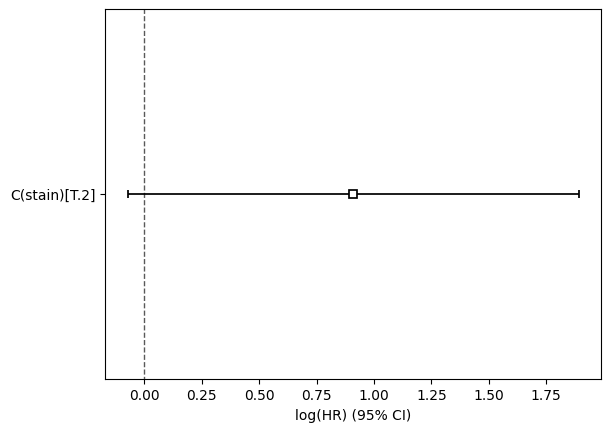

In [10]:
cph.plot()

<Axes: xlabel='HR (95% CI)'>

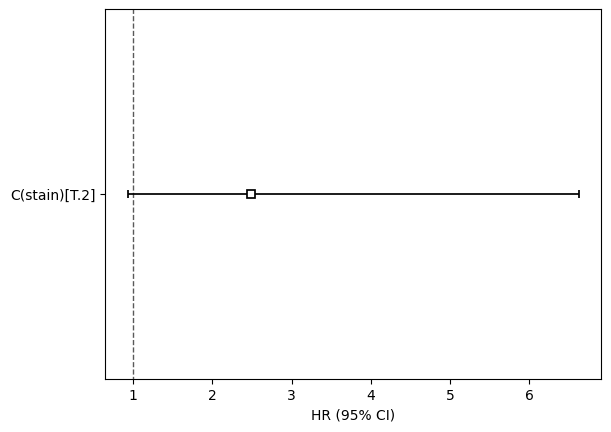

In [11]:
cph.plot(hazard_ratios=True)

The hazard ratio is given by $$\psi=\exp(\beta).$$ We can conclude that a woman who has positively stained will have around 2.48 more risk of dying  at any given time.

Furthermore, the $P$-value for the hypothesis that $\beta=0$ is 0.07, which can be translated as slight evidence against the hypothesis of equal hazard

In [12]:
ZStatistic = cph.summary['coef'] / cph.summary['se(coef)']
ZStatistic

covariate
C(stain)[T.2]    1.815288
dtype: float64

In [13]:
PValue = 2*norm.sf(np.abs(ZStatistic))
PValue

array([0.06947962])

$-2\log$-likelihood statistic

In [14]:
-2*cph.log_likelihood_

170.02995571337104

The log-likelihood ratio test allows us to compare the model with against the null model, which has no covariates.

The test statistic is $$-2\log\text{-likelihood}_{\text{Null}}+2\log\text{-likelihood}_{\text{Model}}$$

In [15]:
cph.log_likelihood_ratio_test()

<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 1
        test_name = log-likelihood ratio test

---
 test_statistic    p  -log2(p)
           3.88 0.05      4.36

We can conclude that there is slight evidence that the hazard functions for the two groups of women are different.